# Reproducibility of the paper: "On Analyzing Generative and Denoising Capabilities of Diffusion-based Deep Generative Models"

[1] Kamil Deja, Anna Kuzina, Tomasz Trzcin ́ski, Jakub M. Tomczak. On Analyzing Generative and Denoising Capabilities of Diffusion-based Deep Generative Models. NeurIPS 2022.

## 1: Prepare the working environment.

### Mount and installation

Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/BayesianML/

/content/drive/MyDrive/BayesianML


Cloning the repo with common setup

In [3]:
# ! git clone https://github.com/David-cripto/FSDDPM

In [4]:
%cd /content/drive/MyDrive/BayesianML/FSDDPM

/content/drive/MyDrive/BayesianML/FSDDPM


Install the dependencies according to the repository's instructions.

In [5]:
# ! pip install -e .

Install additional libraries.

In [5]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

### Code for the following training and sampling

Function from the seminar to display images

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

def show_images(x, padding=0):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, padding=padding)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def image_grid(imgs, rows, cols, scale=2):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*int(w*scale), rows*int(h*scale)))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img.resize((int(w*scale), int(h*scale))),
                   box=(i%cols*int(w*scale), i//cols*int(h*scale)))
    return grid

topil = lambda x: ToPILImage()(x.mul(0.5).add(0.5).clip(0, 1))

# Mac users may need device = 'mps' (untested)
device = "cuda" if torch.cuda.is_available() else "cpu"

Loading the dataset, creating data loader

In [7]:
import torchvision
from fsddpm.datasets.colored_mnist import get_dataset

dataset, _ = get_dataset("./")
indices = np.random.choice(len(dataset), size=1000, replace=False)

image_size = 28
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset size and number of batches

In [8]:
len(dataset), len(train_dataloader)

(60000, 469)

Example of dataset samples

X shape: torch.Size([8, 3, 28, 28])


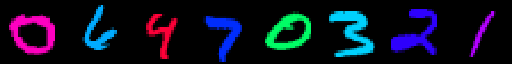

In [9]:
xb = next(iter(train_dataloader))[0].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [10]:
from diffusers import DDPMScheduler

In [11]:
from tqdm import tqdm

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Fix values of $\beta_1$ (similar to the paper) for the following training

In [13]:
beta_1_grid = [0.001, 0.025, 0.05, 0.1, 0.2]
beta_1_grid

[0.001, 0.025, 0.05, 0.1, 0.2]

Helper function to load the model

In [14]:
from fsddpm.methods.model import get_model as get_model_

torch.manual_seed(0)

time_emp_type= "positional"

get_model = lambda : get_model_(sample_size=image_size, time_embedding_type=time_emp_type)

In [15]:
print("Number of parametrs:", round(sum(p.numel() for p in get_model().parameters()) / 1e6, 1), "M")

Number of parametrs: 4.7 M


<ipython-input-15-ca0183d0b2fd>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print("Number of parametrs:", round(sum(p.numel() for p in get_model().parameters()) / 1e6, 1), "M")


In [16]:
from tqdm.auto import tqdm, trange

Helper function: given the set of $\beta$ values from the noise schedule and the value of $\beta_1$, it computes the most appropriate number of time step

In [17]:
def get_time_split(betas, beta_1):
  num_timesteps = len(betas)
  alphas = 1.0 - betas
  alphas_cumprod = torch.cumprod(alphas, dim=0)
  t_split_index = torch.argmin(torch.abs((1 - alphas_cumprod) - beta_1)).item()
  t_split = np.arange(num_timesteps)[t_split_index]
  return t_split

In [18]:
from typing import List, Optional, Tuple, Union
from diffusers.schedulers.scheduling_ddpm import betas_for_alpha_bar
from diffusers.configuration_utils import ConfigMixin, register_to_config

Function that generates standard beta schedule (linear or cosine) and replace the first steps with value of $\beta_1$. This we will need for the following training of DAED model.

In [19]:
def get_betas(beta_start=None, beta_end=None, num_timesteps=1000, schedule_type="squaredcos_cap_v2", beta_1=None):
  betas = None
  if schedule_type == "linear":
    betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)
  elif schedule_type == "squaredcos_cap_v2":
    betas = betas_for_alpha_bar(num_timesteps)
  if beta_1 is not None:
    t_split = get_time_split(betas, beta_1)
    betas = betas[t_split:]
    betas[0] = beta_1
  return betas

Examplary behavior of noise schedules with reduced number of steps for each value of $\beta_1$

In [18]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)

num_timesteps=1000
beta_schedule="squaredcos_cap_v2"

noise_scheduler1 = DDPMScheduler(num_train_timesteps=num_timesteps,
                                 beta_schedule=beta_schedule)

betas = get_betas(None, None, num_timesteps, beta_schedule, beta_1=beta_1_grid[0])
noise_scheduler2 = DDPMScheduler(num_train_timesteps=len(betas),
                                 trained_betas=betas.numpy(),
                                 beta_schedule=beta_schedule)

betas = get_betas(None, None, num_timesteps, beta_schedule, beta_1=beta_1_grid[1])
noise_scheduler3 = DDPMScheduler(num_train_timesteps=len(betas),
                                 trained_betas=betas.numpy(),
                                 beta_schedule=beta_schedule)

betas = get_betas(None, None, num_timesteps, beta_schedule, beta_1=beta_1_grid[2])
noise_scheduler4 = DDPMScheduler(num_train_timesteps=len(betas),
                                 trained_betas=betas.numpy(),
                                 beta_schedule=beta_schedule)

betas = get_betas(None, None, num_timesteps, beta_schedule, beta_1=beta_1_grid[3])
noise_scheduler5 = DDPMScheduler(num_train_timesteps=len(betas),
                                 trained_betas=betas.numpy(),
                                 beta_schedule=beta_schedule)

betas = get_betas(None, None, num_timesteps, beta_schedule, beta_1=beta_1_grid[4])
noise_scheduler6 = DDPMScheduler(num_train_timesteps=len(betas),
                                 trained_betas=betas.numpy(),
                                 beta_schedule=beta_schedule)

Resulting number of time steps for each schedule.

In [19]:
len(noise_scheduler1.betas), len(noise_scheduler2.betas), len(noise_scheduler3.betas), len(noise_scheduler4.betas), len(noise_scheduler5.betas), len(noise_scheduler6.betas)

(1000, 987, 907, 864, 802, 711)

$\beta$ vs time steps for all noise schedules

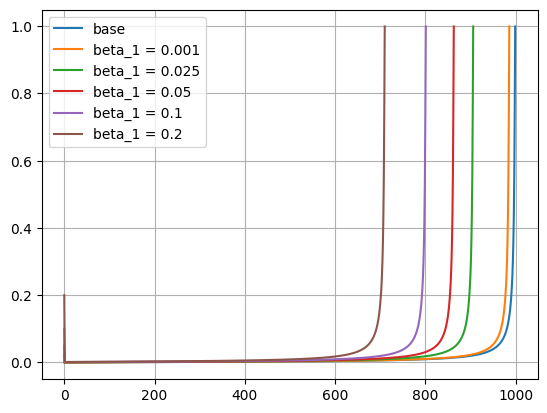

In [20]:
plot(noise_scheduler1.betas, label='base')
plot(noise_scheduler2.betas, label='beta_1 = {}'.format(beta_1_grid[0]))
plot(noise_scheduler3.betas, label='beta_1 = {}'.format(beta_1_grid[1]))
plot(noise_scheduler4.betas, label='beta_1 = {}'.format(beta_1_grid[2]))
plot(noise_scheduler5.betas, label='beta_1 = {}'.format(beta_1_grid[3]))
plot(noise_scheduler6.betas, label='beta_1 = {}'.format(beta_1_grid[4]))
grid()
legend()

$1-\alpha$ vs time steps for all noise schedules

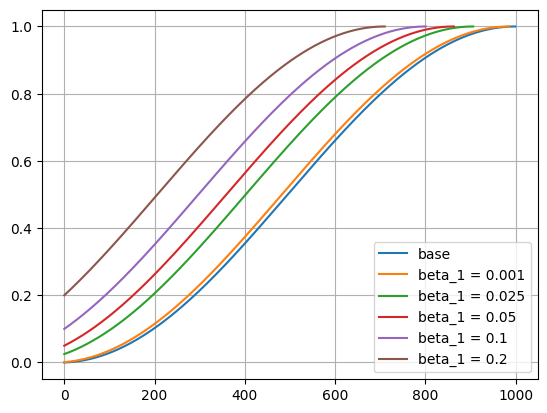

In [21]:
plot(1 - noise_scheduler1.alphas_cumprod, label='base')
plot(1 - noise_scheduler2.alphas_cumprod, label='beta_1 = {}'.format(beta_1_grid[0]))
plot(1 - noise_scheduler3.alphas_cumprod, label='beta_1 = {}'.format(beta_1_grid[1]))
plot(1 - noise_scheduler4.alphas_cumprod, label='beta_1 = {}'.format(beta_1_grid[2]))
plot(1 - noise_scheduler5.alphas_cumprod, label='beta_1 = {}'.format(beta_1_grid[3]))
plot(1 - noise_scheduler6.alphas_cumprod, label='beta_1 = {}'.format(beta_1_grid[4]))
grid()
legend()

For each of noise schedules, display timesteps and noisy images (the first one is standard schedule and the rest are in order of increase of $\beta_1$ value).

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')
tensor([  0, 140, 281, 422, 563, 704, 845, 986], device='cuda:0')
tensor([  0, 129, 258, 388, 517, 647, 776, 906], device='cuda:0')
tensor([  0, 123, 246, 369, 493, 616, 739, 863], device='cuda:0')
tensor([  0, 114, 228, 343, 457, 572, 686, 801], device='cuda:0')
tensor([  0, 101, 202, 304, 405, 507, 608, 710], device='cuda:0')
Noisy X shape torch.Size([8, 3, 28, 28])


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


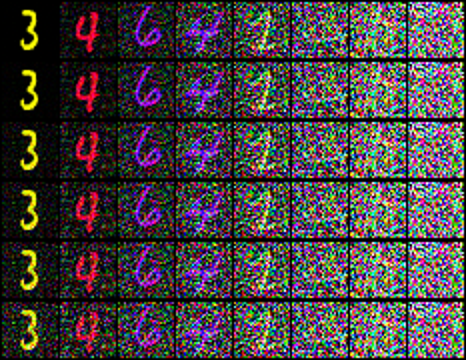

In [22]:
noise = torch.randn_like(xb)

timesteps = torch.linspace(0, noise_scheduler1.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_1 = noise_scheduler1.add_noise(xb, noise, timesteps)

timesteps = torch.linspace(0, noise_scheduler2.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_2 = noise_scheduler2.add_noise(xb, noise, timesteps)

timesteps = torch.linspace(0, noise_scheduler3.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_3 = noise_scheduler3.add_noise(xb, noise, timesteps)

timesteps = torch.linspace(0, noise_scheduler4.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_4 = noise_scheduler4.add_noise(xb, noise, timesteps)

timesteps = torch.linspace(0, noise_scheduler5.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_5 = noise_scheduler5.add_noise(xb, noise, timesteps)

timesteps = torch.linspace(0, noise_scheduler6.num_train_timesteps - 1, 8).long().to(device)
print (timesteps)
noisy_xb_6 = noise_scheduler6.add_noise(xb, noise, timesteps)

print("Noisy X shape", noisy_xb_1.shape)
image_grid([
    show_images(noisy_xb_1, padding=1),
    show_images(noisy_xb_2, padding=1),
    show_images(noisy_xb_3, padding=1),
    show_images(noisy_xb_4, padding=1),
    show_images(noisy_xb_5, padding=1),
    show_images(noisy_xb_6, padding=1),
], 6, 1)

Three types of time steps sampling: UniformSampler is for standard DDPM training. ZeroSampler samples only the time step corresponding to $\beta_1$ and is for training of DAE part of DAED. WeightedSampler is for DAED training and has increased sampling probability for the time step corresponding to $\beta_1$. (Taken from the paper's code because not clear from the paper.)

In [20]:
class UniformSampler():
  def __init__(self, num_timesteps, device):
    self.num_timesteps = num_timesteps
    self.device = device

  def sample(self, bs):
    timesteps = torch.randint(0, self.num_timesteps, (bs,), device=self.device).long()
    return timesteps

class ZeroSampler():
  def __init__(self, num_timesteps, device):
    self.num_timesteps = num_timesteps
    self.device = device

  def sample(self, bs):
    timesteps = torch.zeros((bs,), device=self.device).long()
    return timesteps

class WeightedSampler():
  def __init__(self, num_timesteps, device, beta_1):
    self.num_timesteps = num_timesteps
    self.device = device
    self.beta_1 = beta_1
    # probabilities
    p = np.ones((self.num_timesteps))
    # keep sampling at least uniform
    p[0] = max(self.beta_1 * self.num_timesteps, 1.)
    p = p / np.sum(p)
    self.p = p

  def sample(self, bs):
    timesteps = np.random.choice(self.num_timesteps, size=(bs,), p=self.p)
    timesteps = torch.Tensor(timesteps).long().to(self.device)
    return timesteps

Helper function to save model and schedule as parts of pipeline.

In [21]:
from diffusers import DDPMPipeline

def save_pipeline_ckpt(mode, ddpm_model, dae_model, noise_scheduler, epoch, beta_1=None):

  if mode == 'ddpm':
    ddpm_pipe = DDPMPipeline(unet=ddpm_model, scheduler=noise_scheduler)
    ddpm_pipe.save_pretrained("ddpm_pipeline_epoch{}".format(epoch))
  elif mode == 'dae':
    dae_pipe = DDPMPipeline(unet=dae_model, scheduler=noise_scheduler)
    dae_pipe.save_pretrained("dae_pipeline_beta{}_epoch{}".format(beta_1, epoch))
  elif mode == 'daed':
    ddpm_pipe = DDPMPipeline(unet=ddpm_model, scheduler=noise_scheduler)
    ddpm_pipe.save_pretrained("ddpm_daed_pipeline_beta{}_epoch{}".format(beta_1, epoch))
    dae_pipe = DDPMPipeline(unet=dae_model, scheduler=noise_scheduler)
    dae_pipe.save_pretrained("dae_daed_pipeline_beta{}_epoch{}".format(beta_1, epoch))

Function to train all the models.

In [22]:
def train(mode, data_loader,
          schedule_type, beta_start, beta_end, num_timesteps, beta_1,
          ddpm_lr, dae_lr,
          device, n_epochs,
          resume_ckpt=None):

  # function to train parts of DAED model depending on mode
  # mode: 'ddpm' - standard DDPM training
  #       'dae' - train DAE part of DAED
  #       'daed' - train DAED model, i.e. both dae and diffusion parts

  if resume_ckpt is not None:
    # to resume training from checkpoints
    # resume_ckpt is a list
    # resume_ckpt[0]: ckpt for ddpm unet
    # resume_ckpt[1]: ckpt for dae unet
    # resume_ckpt[2]: ckpt for noise scheduler

    ddpm_model = UNet2DModel.from_pretrained(resume_ckpt[0]).to(device)
    ddpm_model.train()
    dae_model = UNet2DModel.from_pretrained(resume_ckpt[1]).to(device)
    dae_model.train()
    noise_scheduler = DDPMScheduler.from_pretrained(resume_ckpt[2])
    epoch_start = int(resume_ckpt[0].split('/')[0].split('epoch')[1])
    print ('loaded checkpoint from {} epoch'.format(epoch_start))

  else:
    # to start training from scratch
    epoch_start = 0

    # model
    ddpm_model, dae_model = None, None
    if mode in ['ddpm', 'daed']:
      ddpm_model = get_model()
      ddpm_model.to(device)
      ddpm_model.train()
    if mode in ['dae', 'daed']:
      dae_model = get_model()
      dae_model.to(device)
      dae_model.train()

    betas = get_betas(beta_start, beta_end, num_timesteps, schedule_type, beta_1=beta_1)
    noise_scheduler = DDPMScheduler(num_train_timesteps=len(betas),
                                    trained_betas=betas.numpy(),
                                    beta_schedule=schedule_type)

  # optimizer
  ddpm_optimizer, dae_optimizer = None, None
  if mode in ['ddpm', 'daed']:
    ddpm_optimizer = torch.optim.AdamW(ddpm_model.parameters(), lr=ddpm_lr)
  if mode in ['dae', 'daed']:
    dae_optimizer = torch.optim.AdamW(dae_model.parameters(), lr=dae_lr)

  # loss history
  ddpm_loss_history, dae_loss_history = None, None
  if mode in ['ddpm', 'daed']:
    ddpm_loss_history = []
  if mode in ['dae', 'daed']:
    dae_loss_history = []

  # time sampler
  sampler = None
  if mode == 'ddpm':
    sampler = UniformSampler(noise_scheduler.num_train_timesteps, device)
  elif mode == 'dae':
    sampler = ZeroSampler(noise_scheduler.num_train_timesteps, device)
  elif mode == 'daed':
    sampler = WeightedSampler(noise_scheduler.num_train_timesteps, device, beta_1)

  # train loop
  progress_bar = trange(epoch_start, n_epochs, desc='Epoch')
  for epoch in progress_bar:
      for step, batch in enumerate(tqdm(data_loader, leave=False)):

          clean_images = batch[0].to(device)

          # Sample noise to add to the images
          noise = torch.randn(clean_images.shape).to(clean_images.device)
          bs = clean_images.shape[0]

          # Sample a random timestep for each image
          timesteps = sampler.sample(bs)

          # Add noise to the clean images
          noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

          # Split inputs for models
          if mode == 'ddpm':
            index_ddpm = torch.Tensor([1] * bs).bool()
            index_dae = torch.Tensor([1] * 0).bool()
          elif mode == 'dae':
            index_ddpm = torch.Tensor([1] * 0).bool()
            index_dae = torch.Tensor([1] * bs).bool()
          elif mode == 'daed':
            # t = 0 means x_1 => t = 0 - dae, t > 0 - ddpm
            # ddpm input: steps with t > 0
            index_ddpm = (timesteps > 0)
            # dae input: steps with t = 0
            index_dae = (timesteps == 0)

          is_ddpm = (index_ddpm.sum() > 0)
          is_dae = (index_dae.sum() > 0)

          # if epoch == 0 and step == 0:
          #   print ('DDPM: {}, DAE: {}'.format(is_ddpm, is_dae))

          timesteps_ddpm = timesteps[index_ddpm] if is_ddpm else None
          timesteps_dae = timesteps[index_dae] if is_dae else None

          noisy_images_ddpm = noisy_images[index_ddpm] if is_ddpm else None
          noisy_images_dae = noisy_images[index_dae] if is_dae else None

          # Model output
          # check that corresponding inputs are non-empty
          noise_pred, clean_images_pred = None, None
          if is_ddpm:
            # ddpm predicts noise
            noise_pred = ddpm_model(noisy_images_ddpm, timesteps_ddpm).sample
          if is_dae:
            # dae predicts clean images from noisy
            clean_images_pred = dae_model(noisy_images_dae, timesteps_dae).sample

          # Targets
          # ddpm target: real noise with right index
          noise_target = noise[index_ddpm] if is_ddpm else None
          # dae target: clean images with right index
          clean_images_target = clean_images[index_dae] if is_dae else None

          # Loss, backward, step
          if is_ddpm:
            # ddpm loss: mse between target noise and predicted noise
            loss_ddpm = F.mse_loss(noise_pred, noise_target)
            loss_ddpm.backward()
            ddpm_loss_history.append(loss_ddpm.item())
            ddpm_optimizer.step()
            ddpm_optimizer.zero_grad(set_to_none=True)
          if is_dae:
            # dae loss: mse between target clean images and predicted clean images
            loss_dae = F.mse_loss(clean_images_pred, clean_images_target)
            loss_dae.backward()
            dae_loss_history.append(loss_dae.item())
            dae_optimizer.step()
            dae_optimizer.zero_grad(set_to_none=True)

      progress_bar.set_postfix({
          'loss ddpm': sum(ddpm_loss_history[-len(data_loader) :]) / len(data_loader) if mode in ['ddpm', 'daed'] else None,
          'loss dae': sum(dae_loss_history[-len(data_loader) :]) / len(data_loader) if mode in ['dae', 'daed'] else None,
      })

      if epoch % 20 == 0:
        save_pipeline_ckpt(mode, ddpm_model, dae_model, noise_scheduler, epoch, beta_1)

  save_pipeline_ckpt(mode, ddpm_model, dae_model, noise_scheduler, epoch, beta_1)

  if mode == 'ddpm':
    return ddpm_model, ddpm_loss_history, noise_scheduler
  elif mode == 'dae':
    return dae_model, dae_loss_history, noise_scheduler
  elif mode == 'daed':
    return ddpm_model, dae_model, ddpm_loss_history, dae_loss_history, noise_scheduler

Function to get samples from DDPM

In [23]:
def get_ddpm_sample(model, noise_scheduler, num_samples, device, seed=0):

    # standard sampling from ddpm

    model.to(device)
    model.eval()

    sample_size = (num_samples, 3, image_size, image_size)
    torch.manual_seed(seed)
    sample = torch.randn(sample_size).to(device)
    timesteps = np.arange(noise_scheduler.num_train_timesteps)[::-1]
    for t in tqdm(timesteps):
      t = torch.from_numpy(np.repeat(t, num_samples)).long().to(device)
      with torch.no_grad():
        pred = model(sample, t).sample
      sample = noise_scheduler.step(pred, t[0], sample).prev_sample

    return sample

Function to get clean images from noisy images from DAE (not samples)

In [24]:
def get_dae_denoise(model, noise_scheduler, num_samples, dataset, device, seed=0):

    # get denoised images from dae

    model.to(device)
    model.eval()

    np.random.seed(seed)
    index = np.random.choice(a=len(dataset), size=num_samples, replace=False)
    clean_images = torch.stack([dataset[i][0] for i in index]).to(device)
    torch.manual_seed(seed)
    noise = torch.randn(clean_images.shape).to(device)
    timesteps = torch.zeros((num_samples,), device=device).long()
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    clean_images_pred = model(noisy_images, timesteps).sample
    return clean_images, noisy_images, clean_images_pred

Function to get samples from DAED model

In [25]:
def get_daed_sample(dae_model, ddpm_model, ddpm_noise_scheduler, beta_1, num_samples, device, seed=0):

  # get samples from daed model

  ddpm_model.to(device)
  ddpm_model.eval()

  # determine the splitting step of underlying diffusion
  t_split = get_time_split(ddpm_noise_scheduler.betas, beta_1)
  # print ('beta_1={}, t_split={}, num_diffusion_steps={}'.format(beta_1, t_split, len(ddpm_noise_scheduler.betas)-1))
  print ('beta_1={}, t_split={}'.format(beta_1, t_split, ))

  # first, obtain samples from diffusion part
  sample_size = (num_samples, 3, image_size, image_size)
  torch.manual_seed(seed)
  sample = torch.randn(sample_size).to(device)
  timesteps = np.arange(ddpm_noise_scheduler.num_train_timesteps)[::-1]
  timesteps = timesteps[timesteps > t_split]
  # print (timesteps)
  for t in tqdm(timesteps):
      t = torch.from_numpy(np.repeat(t, num_samples)).long().to(device)
      with torch.no_grad():
        pred = ddpm_model(sample, t).sample
      sample = ddpm_noise_scheduler.step(pred, t[0], sample).prev_sample

  # second, pass samples from diffusion to DAE
  dae_model.to(device)
  dae_model.eval()
  dae_timesteps = torch.zeros((num_samples,), device=device).long()
  final_sample = dae_model(sample, dae_timesteps).sample
  return sample, final_sample

## 2: Training the models

### Train DDPM

Train DDPM model in a standard way.

In [ ]:
# training takes more than 3 hours

# schedule_type = 'squaredcos_cap_v2'
# num_timesteps = 1000
# lr = 1e-4
# n_epochs = 70
# ddpm_model, ddpm_losses_history, ddpm_noise_scheduler = train(mode='ddpm', data_loader=train_dataloader,
#                                         schedule_type=schedule_type, beta_start=None, beta_end=None,
#                                         num_timesteps=num_timesteps, beta_1=None,
#                                         ddpm_lr=lr, dae_lr=None,
#                                         device=device, n_epochs=n_epochs)

### Train DAE part of DAED model

Train several DAEs for different $\beta_1$ with trained DDPM.

In [ ]:
# # training takes more than 2 hours

# from copy import deepcopy

# schedule_type = 'squaredcos_cap_v2'
# num_timesteps = 1000
# lr = 1e-4
# n_epochs = 10
# dae_models = {}
# dae_losses_histories = {}
# dae_schedulers = {}
# for beta_1 in beta_1_grid:
#   print ('beta_1 = {}'.format(beta_1))
#   dae_model, dae_losses_history, dae_scheduler = train(mode='dae', data_loader=train_dataloader,
#                                         schedule_type=schedule_type, beta_start=None, beta_end=None,
#                                         num_timesteps=num_timesteps, beta_1=beta_1,
#                                         ddpm_lr=None, dae_lr=lr,
#                                         device=device, n_epochs=n_epochs)
#   dae_models[beta_1] = deepcopy(dae_model)
#   dae_losses_histories[beta_1] = dae_losses_history
#   dae_schedulers[beta_1] = dae_scheduler

Convergence plots for different values of $\beta_1$ (log-scale).

Populating the interactive namespace from numpy and matplotlib


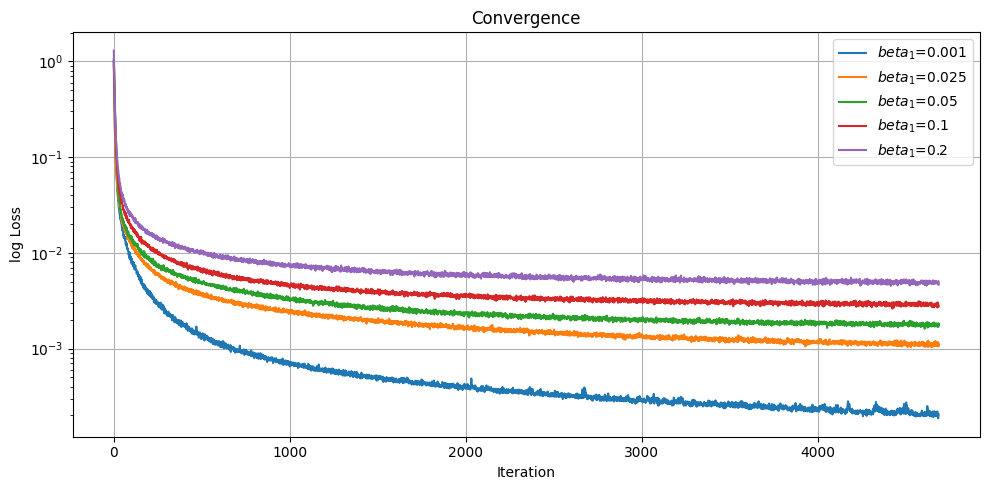

In [ ]:
%pylab inline
fig, ax = subplots(nrows=1, ncols=1, figsize=(10, 5), tight_layout=True)
for beta_1 in dae_losses_histories:
  ax.plot(dae_losses_histories[beta_1], label='$beta_1$={}'.format(beta_1))
ax.grid()
ax.set_title('Convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('log Loss')
ax.legend()
ax.set_yscale('log')

### Train DAED model

Train full pipeline DAED models with $\beta_1=0.001$ and $\beta_1=0.1$.

In [ ]:
# training takes more than 3 hours

# schedule_type = 'squaredcos_cap_v2'
# num_timesteps = 1000
# lr = 1e-4
# n_epochs = 70
# beta_1 = 0.1
# ddpm_model, dae_model, ddpm_loss_history, dae_loss_history, daed_noise_schedule = train(mode='daed', data_loader=train_dataloader,
#                                         schedule_type=schedule_type, beta_start=None, beta_end=None,
#                                         num_timesteps=num_timesteps, beta_1=beta_1,
#                                         ddpm_lr=lr, dae_lr=lr,
#                                         device=device, n_epochs=n_epochs)

In [ ]:
# training takes more than 3 hours

# schedule_type = 'squaredcos_cap_v2'
# num_timesteps = 1000
# lr = 1e-4
# n_epochs = 70
# beta_1 = 0.001
# ddpm_model, dae_model, ddpm_loss_history, dae_loss_history, daed_noise_schedule = train(mode='daed', data_loader=train_dataloader,
#                                         schedule_type=schedule_type, beta_start=None, beta_end=None,
#                                         num_timesteps=num_timesteps, beta_1=beta_1,
#                                         ddpm_lr=lr, dae_lr=lr,
#                                         device=device, n_epochs=n_epochs)

## 3: Analysis of trained model

In this section we analyze the trained models.

#### The noise distribution in the forward diffusion process

Similar to [1], we explore how much corrupted an image gets after applying a specific noise schedule using the following SNR notion:

$$\text{SNR}(x_0, t) = \frac{\bar{\alpha_t}x_0^2}{1 - \bar{\alpha}_t}$$

We explore SNR for linear and cosine noise schedules.

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Cosine noise schedule')

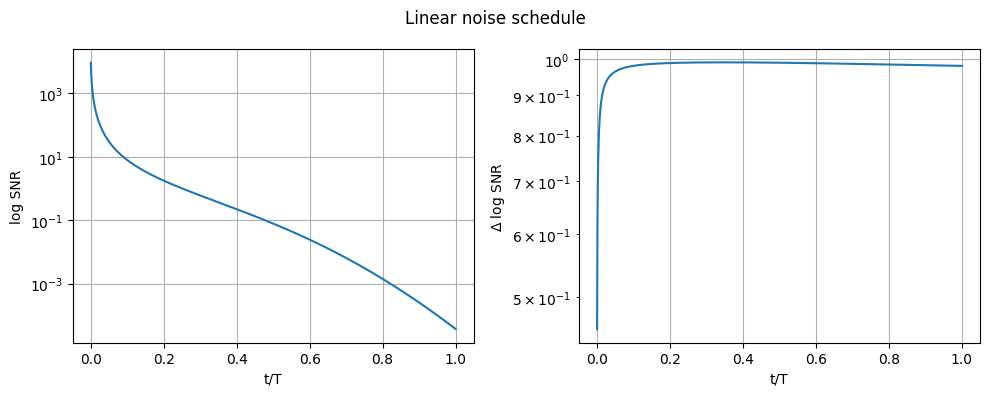

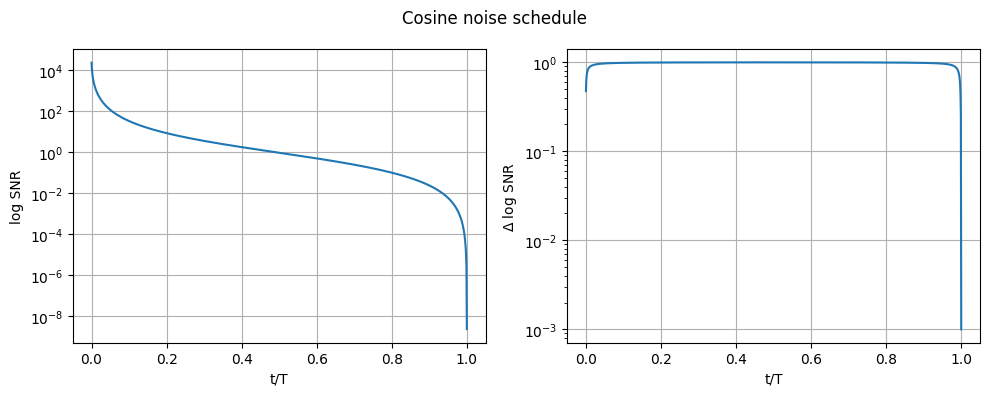

In [ ]:
# helper functions for snr computation
snr_lin = lambda x: noise_scheduler_lin.alphas_cumprod.cpu() * torch.mean(x ** 2) / (1 - noise_scheduler_lin.alphas_cumprod.cpu())
snr_cos = lambda x: noise_scheduler_cos.alphas_cumprod.cpu() * torch.mean(x ** 2) / (1 - noise_scheduler_cos.alphas_cumprod.cpu())

# compute snr over the whole dataset
snr_dataset_lin = torch.stack([snr_lin(dataset[i][0]) for i in tqdm(range(len(dataset)))])
snr_dataset_cos = torch.stack([snr_cos(dataset[i][0]) for i in tqdm(range(len(dataset)))])

# plot snr for linear schedule
fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)

x = np.linspace(0, 1, len(noise_scheduler_lin.betas))
ax[0].plot(x, torch.mean(snr_dataset_lin, dim=0))
ax[0].fill_between(x,
             torch.mean(snr_dataset_lin, dim=0) - torch.std(snr_dataset_lin, dim=0),
             torch.mean(snr_dataset_lin, dim=0) + torch.std(snr_dataset_lin, dim=0),
             alpha=0.3)
ax[0].set_yscale('log')
ax[0].set_xlabel('t/T')
ax[0].set_ylabel('log SNR')
ax[0].grid()

delta = snr_dataset_lin[:, 1:] / snr_dataset_lin[:, :-1]
ax[1].plot(x[1:], torch.mean(delta, dim=0))
ax[1].fill_between(x[1:],
                   torch.mean(delta, dim=0) - torch.std(delta, dim=0),
                   torch.mean(delta, dim=0) + torch.std(delta, dim=0),
                   alpha = 0.3)
ax[1].set_yscale('log')
ax[1].set_xlabel('t/T')
ax[1].set_ylabel('$\Delta$ log SNR')
ax[1].grid()

fig.suptitle('Linear noise schedule')

# plot snr for cosine schedule
fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)

x = np.linspace(0, 1, len(noise_scheduler_cos.betas))
ax[0].plot(x, torch.mean(snr_dataset_cos, dim=0))
ax[0].fill_between(x,
             torch.mean(snr_dataset_cos, dim=0) - torch.std(snr_dataset_cos, dim=0),
             torch.mean(snr_dataset_cos, dim=0) + torch.std(snr_dataset_cos, dim=0),
             alpha=0.3)
ax[0].set_yscale('log')
ax[0].set_xlabel('t/T')
ax[0].set_ylabel('log SNR')
ax[0].grid()

delta = snr_dataset_cos[:, 1:] / snr_dataset_cos[:, :-1]
ax[1].plot(x[1:], torch.mean(delta, dim=0))
ax[1].fill_between(x[1:],
                   torch.mean(delta, dim=0) - torch.std(delta, dim=0),
                   torch.mean(delta, dim=0) + torch.std(delta, dim=0),
                   alpha = 0.3)
ax[1].set_yscale('log')
ax[1].set_xlabel('t/T')
ax[1].set_ylabel('$\Delta$ log SNR')
ax[1].grid()

fig.suptitle('Cosine noise schedule')

Similarly to [1], we observe that $\log{SNR}$ drops below $0$ for about $30\%$ of steps for linear schedule and for about $50\%$ of steps for cosine schedule. Also we find that the biggest change happens in the first $10\%$ of steps.

#### Sample Quality of DDPM

Samples from the DDPM model

In [ ]:
from diffusers import UNet2DModel

In [ ]:
ddpm_model = UNet2DModel.from_pretrained('ddpm_pipeline_epoch69/unet')
ddpm_noise_scheduler = DDPMScheduler.from_pretrained('ddpm_pipeline_epoch69/scheduler')

In [ ]:
ddpm_samples = get_ddpm_sample(ddpm_model, ddpm_noise_scheduler, 8, device, seed=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 223.5, 27.5, -0.5)

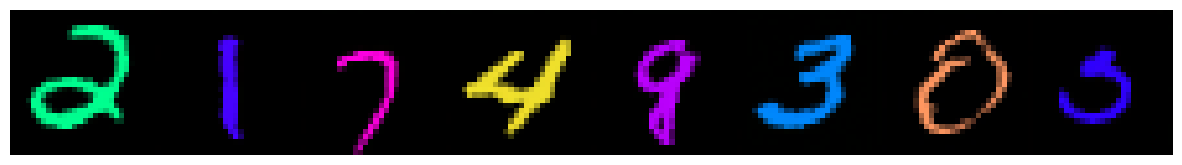

In [ ]:
imshow(show_images(ddpm_samples).resize((8 * 28, 28)))
axis('off')

#### Sample Quality DAE part of DAED

Quality images denoised by DAEs (not samples)

  0%|          | 0/5 [00:00<?, ?it/s]

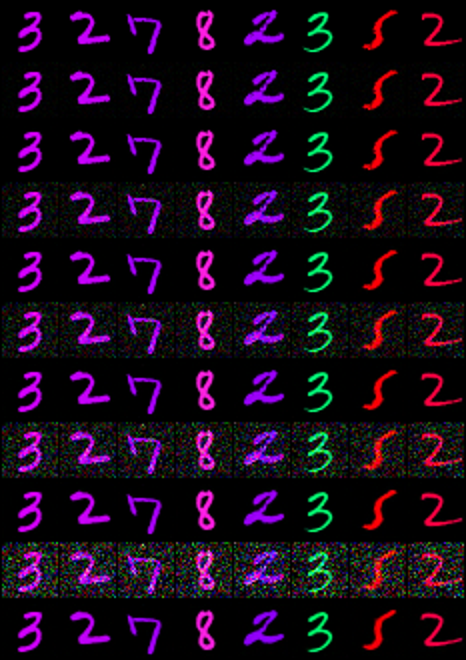

In [ ]:
dae_clean_images = {}
dae_noisy_images = {}
dae_clean_images_pred = {}
for beta_1 in tqdm(dae_models):
  dae_clean_images[beta_1], dae_noisy_images[beta_1], dae_clean_images_pred[beta_1] = get_dae_denoise(dae_models[beta_1],
                                                                                                      dae_schedulers[beta_1],
                                                                                                      8, dataset, device, seed=1)

figsize(15, 7)
im_list = [dae_clean_images[beta_1]]
for beta_1 in dae_noisy_images:
  im_list.append(dae_noisy_images[beta_1])
  im_list.append(dae_clean_images_pred[beta_1])
image_grid([show_images(x, padding=1) for x in im_list], len(im_list), 1)

The first line is true clean images. In the following, each pair of lines is noisy images and images denoised by DAE in the order of $\beta_1$ increase.

Samples of the DAED models, i.e. the same pretrained DDPM and different trained DAEs corresponding to different values of $\beta_1$.

In [ ]:
dae_samples_grid = {}
dae_final_samples_grid = {}
for beta_1 in dae_models:
  dae_samples_grid[beta_1], dae_final_samples_grid[beta_1] = get_daed_sample(dae_models[beta_1],
                                                                       ddpm_model, ddpm_noise_scheduler, beta_1, 8, device, 1)

beta_1=0.001, t_split=13


  0%|          | 0/986 [00:00<?, ?it/s]

beta_1=0.025, t_split=93


  0%|          | 0/906 [00:00<?, ?it/s]

beta_1=0.05, t_split=136


  0%|          | 0/863 [00:00<?, ?it/s]

beta_1=0.1, t_split=198


  0%|          | 0/801 [00:00<?, ?it/s]

beta_1=0.2, t_split=289


  0%|          | 0/710 [00:00<?, ?it/s]

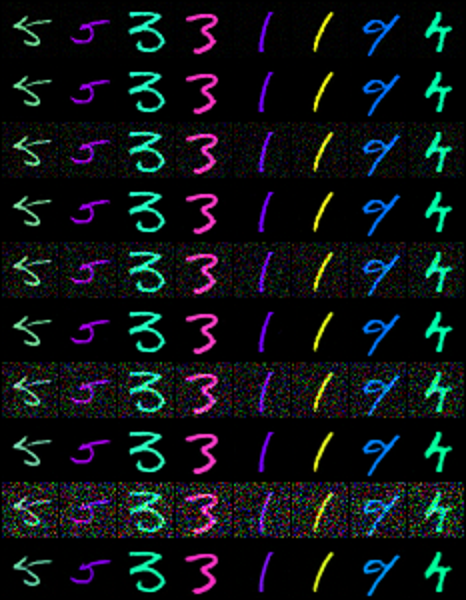

In [ ]:
figsize(15, 7)
im_list = []
for b1_1, b1_2 in zip(dae_samples_grid, dae_final_samples_grid):
  im_list.append(dae_samples_grid[b1_1])
  im_list.append(dae_final_samples_grid[b1_2])
image_grid([show_images(x, padding=1) for x in im_list], len(im_list), 1)

From top to bottom: each pair of lines is noisy images from diffusion part and images denoised by DAEs (i.e. samples from the full DAED models) in the order of $\beta_1$ increase.

#### Sample Quality DAED

DAED with $\beta_1=0.001$

In [ ]:
ddpm_model_daed1 = UNet2DModel.from_pretrained('ddpm_daed_pipeline_beta0.001_epoch69/unet')
dae_model_daed1 = UNet2DModel.from_pretrained('dae_daed_pipeline_beta0.001_epoch69/unet')
daed_noise_scheduler1 = DDPMScheduler.from_pretrained('ddpm_daed_pipeline_beta0.001_epoch69/scheduler')

In [ ]:
daed_samples_from_diff1, daed_samples_from_dae1, = get_daed_sample(dae_model_daed1,
                                ddpm_model_daed1,
                                daed_noise_scheduler1,
                                beta_1=0.001,
                                num_samples=8,
                                device=device, seed=1)

beta_1=0.001, t_split=0, num_diffusion_steps=986


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/986 [00:00<?, ?it/s]

Samples from the diffusion part

(-0.5, 223.5, 27.5, -0.5)

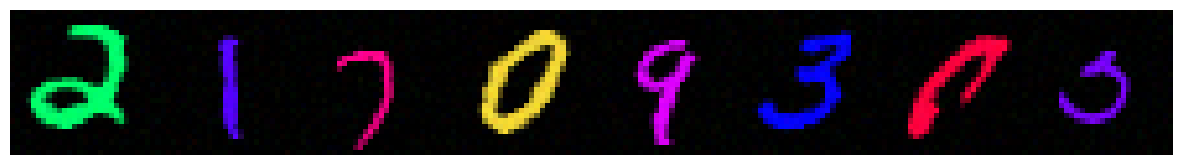

In [ ]:
imshow(show_images(daed_samples_from_diff1).resize((8 * 28, 28)))
axis('off')

Previous samples passed to DAE, i.e. samples from DAED model

(-0.5, 223.5, 27.5, -0.5)

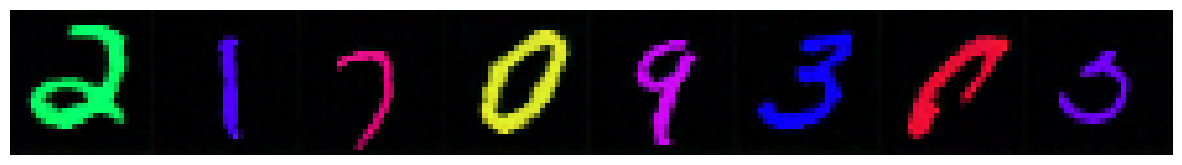

In [ ]:
imshow(show_images(daed_samples_from_dae1).resize((8 * 28, 28)))
axis('off')

DAED with $\beta_1=0.1$

In [ ]:
ddpm_model_daed2 = UNet2DModel.from_pretrained('ddpm_daed_pipeline_beta0.1_epoch69/unet')
dae_model_daed2 = UNet2DModel.from_pretrained('dae_daed_pipeline_beta0.1_epoch69/unet')
daed_noise_scheduler2 = DDPMScheduler.from_pretrained('ddpm_daed_pipeline_beta0.1_epoch69/scheduler')

In [ ]:
daed_samples_from_diff2, daed_samples_from_dae2, = get_daed_sample(dae_model_daed2,
                                ddpm_model_daed2,
                                daed_noise_scheduler2,
                                beta_1=0.1,
                                num_samples=8,
                                device=device, seed=2)

beta_1=0.1, t_split=0, num_diffusion_steps=801


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/801 [00:00<?, ?it/s]

Samples from the diffusion part

(-0.5, 223.5, 27.5, -0.5)

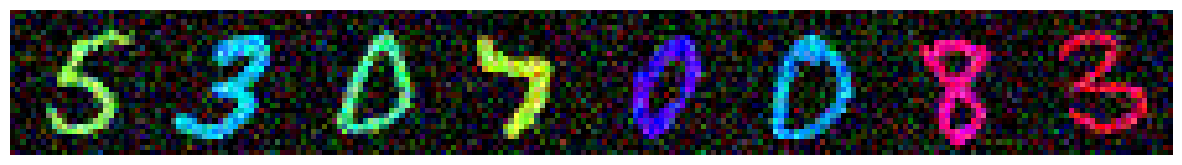

In [ ]:
imshow(show_images(daed_samples_from_diff2).resize((8 * 28, 28)))
axis('off')

Previous samples passed to DAE, i.e. samples from DAED model

(-0.5, 223.5, 27.5, -0.5)

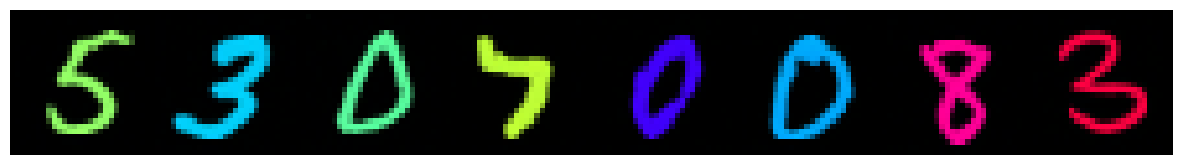

In [ ]:
imshow(show_images(daed_samples_from_dae2).resize((8 * 28, 28)))
axis('off')

#### FID score

To compute the FID score, we use the library https://github.com/mseitzer/pytorch-fid.

First, we prepare samples from the dataset and from the trained models.

In [33]:
# ! pip install scipy==1.11.1

In [34]:
# ! pip install pytorch-fid

In [26]:
import os
from PIL import Image

In [39]:
def save_img_to_file(x_0, path):
  for i in tqdm(range(x_0.shape[0])):
      img = (x_0[i].permute(1,2,0) * 0.5 + 0.5).clip(0, 1).cpu().numpy()*255
      img = img.astype(np.uint8)
      os.makedirs(path, exist_ok=True)
      Image.fromarray(img).save(os.path.join(path, 'image_{}.png'.format(i)))

In [28]:
from diffusers import UNet2DModel
from diffusers import DDPMScheduler

ddpm_model = UNet2DModel.from_pretrained('ddpm_pipeline_epoch69/unet').to(device).eval()
ddpm_noise_scheduler = DDPMScheduler.from_pretrained('ddpm_pipeline_epoch69/scheduler')

In [32]:
n_samples = 200

In [52]:
ddpm_samples = get_ddpm_sample(ddpm_model, ddpm_noise_scheduler, n_samples, device, seed=1)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
save_img_to_file(ddpm_samples, 'ddpm_samples2')

  0%|          | 0/200 [00:00<?, ?it/s]

In [55]:
dae_samples = {}
for i, beta_1 in enumerate(beta_1_grid):
  print (beta_1)
  path = 'dae_pipeline_beta{}_epoch9'.format(beta_1)
  dae_model = UNet2DModel.from_pretrained(os.path.join(path, 'unet'))
  dae_samples = get_daed_sample(dae_model, ddpm_model, ddpm_noise_scheduler, beta_1, n_samples, device, 1)[1].detach().cpu()
  save_img_to_file(dae_samples, 'dae_samples2_beta{}'.format(beta_1))

0.001
beta_1=0.001, t_split=13


  0%|          | 0/986 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.025
beta_1=0.025, t_split=93


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.05
beta_1=0.05, t_split=136


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.1
beta_1=0.1, t_split=198


  0%|          | 0/801 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.2
beta_1=0.2, t_split=289


  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
ddpm_model_daed1 = UNet2DModel.from_pretrained('ddpm_daed_pipeline_beta0.001_epoch69/unet')
dae_model_daed1 = UNet2DModel.from_pretrained('dae_daed_pipeline_beta0.001_epoch69/unet')
daed_noise_scheduler1 = DDPMScheduler.from_pretrained('ddpm_daed_pipeline_beta0.001_epoch69/scheduler')

In [47]:
daed_samples_from_diff1, daed_samples_from_dae1, = get_daed_sample(dae_model_daed1,
                                ddpm_model_daed1,
                                daed_noise_scheduler1,
                                beta_1=0.001,
                                num_samples=n_samples,
                                device=device, seed=1)

beta_1=0.001, t_split=0


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/986 [00:00<?, ?it/s]

In [50]:
save_img_to_file(daed_samples_from_dae1.detach().cpu(), 'daed_samples2_beta0.001')

  0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
ddpm_model_daed2 = UNet2DModel.from_pretrained('ddpm_daed_pipeline_beta0.1_epoch69/unet')
dae_model_daed2 = UNet2DModel.from_pretrained('dae_daed_pipeline_beta0.1_epoch69/unet')
daed_noise_scheduler2 = DDPMScheduler.from_pretrained('ddpm_daed_pipeline_beta0.1_epoch69/scheduler')

In [42]:
daed_samples_from_diff2, daed_samples_from_dae2, = get_daed_sample(dae_model_daed2,
                                ddpm_model_daed2,
                                daed_noise_scheduler2,
                                beta_1=0.1,
                                num_samples=n_samples,
                                device=device, seed=1)

beta_1=0.1, t_split=0


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/801 [00:00<?, ?it/s]

In [44]:
save_img_to_file(daed_samples_from_dae2.detach().cpu(), 'daed_samples2_beta0.1')

  0%|          | 0/200 [00:00<?, ?it/s]

Compute FID scores

In [56]:
! python -m pytorch_fid colored_mnist_train ddpm_samples2

100% 22/22 [00:04<00:00,  4.44it/s]
100% 4/4 [00:01<00:00,  3.86it/s]
FID:  25.938778247369868


In [57]:
! python -m pytorch_fid colored_mnist_train dae_samples2_beta0.001/

100% 22/22 [00:04<00:00,  4.64it/s]
100% 4/4 [00:01<00:00,  3.36it/s]
FID:  26.210471716850293


In [58]:
! python -m pytorch_fid colored_mnist_train dae_samples2_beta0.025/

100% 22/22 [00:04<00:00,  4.59it/s]
100% 4/4 [00:01<00:00,  3.43it/s]
FID:  26.38413456787191


In [59]:
! python -m pytorch_fid colored_mnist_train dae_samples2_beta0.05/

100% 22/22 [00:04<00:00,  4.51it/s]
100% 4/4 [00:01<00:00,  3.80it/s]
FID:  26.517880948969236


In [60]:
! python -m pytorch_fid colored_mnist_train dae_samples2_beta0.1/

100% 22/22 [00:05<00:00,  4.13it/s]
100% 4/4 [00:01<00:00,  3.76it/s]
FID:  26.930079760263027


In [61]:
! python -m pytorch_fid colored_mnist_train dae_samples2_beta0.2/

100% 22/22 [00:05<00:00,  4.21it/s]
100% 4/4 [00:01<00:00,  3.79it/s]
FID:  28.072681958300365


In [62]:
! python -m pytorch_fid colored_mnist_train daed_samples2_beta0.001/

100% 22/22 [00:05<00:00,  4.37it/s]
100% 4/4 [00:01<00:00,  2.19it/s]
FID:  37.60923058532262


In [63]:
! python -m pytorch_fid colored_mnist_train daed_samples2_beta0.1/

100% 22/22 [00:04<00:00,  4.47it/s]
100% 4/4 [00:01<00:00,  3.56it/s]
FID:  24.898094980613763


For each model, let us plot the FID scores vs NFE (number of function evaluations).

In [64]:
fid_scores = {'DDPM': 25.938778247369868,
              'DAE part DAED $beta_1=0.001$': 26.210471716850293,
              'DAE part DAED $beta_1=0.025$': 26.38413456787191,
              'DAE part DAED $beta_1=0.05$': 26.517880948969236,
              'DAE part DAED $beta_1=0.1$': 26.930079760263027,
              'DAE part DAED $beta_1=0.2$': 28.072681958300365,
              'DAED $beta_1=0.001$': 37.60923058532262,
              'DAED $beta_1=0.1$': 24.898094980613763,
              }
nfe_scores = {'DDPM': 1000,
              'DAE part DAED $beta_1=0.001$': 987,
              'DAE part DAED $beta_1=0.025$': 907,
              'DAE part DAED $beta_1=0.05$': 864,
              'DAE part DAED $beta_1=0.1$': 802,
              'DAE part DAED $beta_1=0.2$': 711,
              'DAED $beta_1=0.001$': 987,
              'DAED $beta_1=0.1$': 802,
              }

Text(0, 0.5, 'FID')

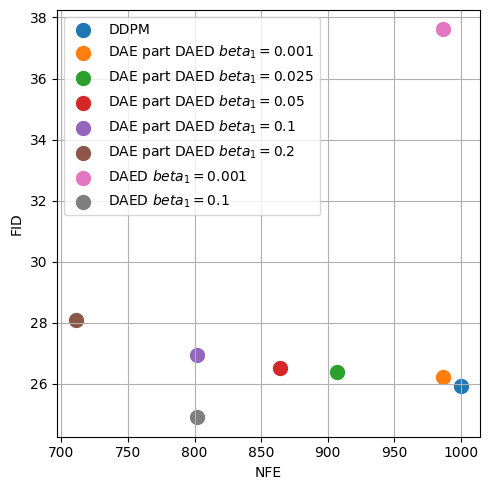

In [65]:
fig, ax = subplots(nrows=1, ncols=1, figsize=(5, 5), tight_layout=True)
for label, _ in zip(fid_scores, nfe_scores):
  ax.scatter(nfe_scores[label], fid_scores[label], label=label, s=100)
ax.grid()
ax.legend()
ax.set_xlabel('NFE')
ax.set_ylabel('FID')